# Constraints on drifts

<!-- SUMMARY: Estimation and Simulations performed in the framework of SPDE -->

<!-- CATEGORY: SPDE -->

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import numpy as np
import matplotlib.pyplot as plt

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

This tutorial has two essential taks:

- cross-check the calculation of the Log-Likelihood (by hand or with gstlearn)
- design the definition pattern for the linkage of the drift functions in the multivariable framework

## Parameters

In [2]:
# Data
np.random.seed(123)
ndat = 100
ndim = 2

# Model
rangev = 0.2
sill = 1.
nugget = 0.1

In [3]:
# Z : vecteur des données
# Covmat : matrice de covariance
# drift : matrice de drift
# A et c permettent d'encoder les contraintes sur le vecteur des coefficients beta :
# sous la forme A * beta = c

def estimCoeff(Z,Covmat,drift,A=None,c=None):
    if A is not None and c is not None: 
        if A.shape[0]!= len(c) or  A.shape[1]!=drift.shape[1]:
            return np.nan
    
    invcovmat = np.linalg.inv(Covmat)
    invu = np.linalg.inv(X.T@invcovmat@X)
    estimatedCoeffs = invu@X.T@invcovmat@Z
    
    if A is None or c is None :
        return estimatedCoeffs
    
    temp = invu@A.T@np.linalg.inv(A@invu@A.T)
    return estimatedCoeffs - temp@A@estimatedCoeffs+temp@c

def computeLogLikelihood(Z,Covmat,drift,coeffs=None,A=None,c=None):
    if coeffs is None:
        coeffs = estimCoeff(Z,Covmat,A,c)
    Zc = Z - coeffs@drift.T
    cholcovmat = np.linalg.cholesky(Covmat)
    Zcstd = np.linalg.solve(cholcovmat,Zc) 
    quad = Zcstd.T@Zcstd
    logdet = 2. * np.sum(np.log(np.diag(cholcovmat)))
    return -0.5 * (quad + logdet + len(Z) * np.log(2.* np.pi))


## Mono variate case

### Model

In [4]:
model = gl.Model.createFromParam(gl.ECov.MATERN,param=1,range=rangev,sill=sill)
model.addCovFromParam(gl.ECov.NUGGET,sill=nugget)
model


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Matern (Third Parameter = 1)
- Sill         =      1.000
- Range        =      0.200
- Theo. Range  =      0.058
Nugget Effect
- Sill         =      0.100
Total Sill     =      1.100
Known Mean(s)     0.000

### Data

In [5]:
dat = gl.Db.createFillRandom(ndat, ndim, 0)
dat["drift"] = dat["x-1"]
gl.simtub(None,dat,model)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x-1 - Locator = x1
Column = 2 - Name = x-2 - Locator = x2
Column = 3 - Name = drift - Locator = NA
Column = 4 - Name = Simu - Locator = z1

In [6]:
truecoeffs = [0.5]
dat["Simu"] = truecoeffs[0] + dat["Simu"]
#dat.setLocator("drift",gl.ELoc.F)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x-1 - Locator = x1
Column = 2 - Name = x-2 - Locator = x2
Column = 3 - Name = drift - Locator = NA
Column = 4 - Name = Simu - Locator = z1

In [7]:
model.setDriftIRF(0,0)
model


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 1
Number of drift equation(s)  = 1

Covariance Part
---------------
Matern (Third Parameter = 1)
- Sill         =      1.000
- Range        =      0.200
- Theo. Range  =      0.058
Nugget Effect
- Sill         =      0.100
Total Sill     =      1.100

Drift Part
----------
Universality_Condition

In [8]:
X = model.evalDriftMatrix(dat).toTL()
Covmat = model.evalCovMatrixSymmetric(dat).toTL()

In [9]:
A = np.array([1]).reshape(1,1)
c = [0.3]

estimCoeff(dat["Simu"],Covmat,X,A,c)

array([0.3])

In [10]:
estimCoeff(dat["Simu"],Covmat,X)

array([0.72774768])

This lack of constraint can be emulated in gstlearn

In [11]:
likelihood = model.computeLogLikelihood(dat, True)

print(f"Compute manual loglikelihood = " + str(np.round(computeLogLikelihood(dat["Simu"],Covmat,X),6)))

Likelihood calculation:
- Number of active samples     = 100
- Number of variables          = 1
- Length of Information Vector = 100
- Number of drift conditions = 1
Optimal Drift coefficients = 
     0.728
Log-Determinant = -33.879144
Quadratic term = 90.846364
Log-likelihood = -120.377463
Compute manual loglikelihood = -120.377463


## Multivariate

In [12]:
s1=0.4
s2=2
r = 0.8
sills = np.array([[s1**2,r*s1*s2],[r*s1*s2,s2**2]])
model = gl.Model.createFromParam(gl.ECov.MATERN,param=1,range=rangev,sills=sills)

In [13]:
ndat=200
dat = gl.Db.createFillRandom(ndat, ndim, 0,2)
dat["drift"] = dat["x-1"]
gl.simtub(None,dat,model)
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 200

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x-1 - Locator = x1
Column = 2 - Name = x-2 - Locator = x2
Column = 3 - Name = f-1 - Locator = f1
Column = 4 - Name = f-2 - Locator = f2
Column = 5 - Name = drift - Locator = NA
Column = 6 - Name = Simu.1 - Locator = z1
Column = 7 - Name = Simu.2 - Locator = z2

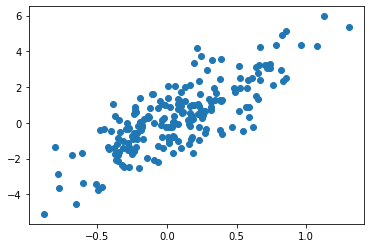

In [14]:
ax = plt.scatter(dat["Simu.1"],dat["Simu.2"])

In [15]:
truecoeffs1 = [0.5,3]
truecoeffs2 = [1.5,-2]
model.setDriftIRF(0,1)
dat["Simu.1"] =  truecoeffs1[0] + truecoeffs1[1] * dat["drift"] + dat["Simu.1"]
dat["Simu.2"] =  truecoeffs2[0] + truecoeffs2[1] * dat["drift"] + dat["Simu.2"]
dat.setLocator("drift",gl.ELoc.F)

### No constraint

In [16]:
Covmat = model.evalCovMatrixSymmetric(dat).toTL()
X = model.evalDriftMatrix(dat).toTL()

In [17]:
Z = dat["Simu*"]
Z=Z.T.reshape(-1)

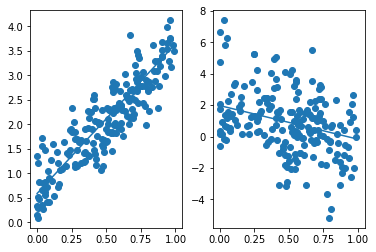

In [18]:
coeffs = estimCoeff(Z,Covmat,X)
fig,ax = plt.subplots(1,2)
ax[0].scatter(dat["x-1"],dat["Simu.1"])
ax[0].plot([0,1],[coeffs[0],coeffs[0]+coeffs[1]])
ax[1].scatter(dat["x-1"],dat["Simu.2"])
ax[1].plot([0,1],[coeffs[2],coeffs[2]+coeffs[3]])

In [19]:
print(f"No Constraint {str(np.round(coeffs,6))}")

No Constraint = [ 0.591383  3.049498  1.968406 -2.140452]


This option can be emulated in gstlearn

In [20]:
likelihood = model.computeLogLikelihood(dat, True)

Likelihood calculation:
- Number of active samples     = 200
- Number of variables          = 2
- Length of Information Vector = 400
- Number of drift conditions = 4
Optimal Drift coefficients = 
     0.591     3.049     1.968    -2.140
Log-Determinant = -676.517039
Quadratic term = 484.076013
Log-likelihood = -271.354901


### Means of both variables are imposed

In [21]:
A = np.array([[1,0,0,0],[0,0,1,0]])
c = [0.5,1.5]
coeffs=estimCoeff(Z,Covmat,X,A,c)

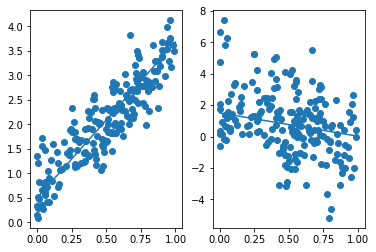

In [22]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(dat["x-1"],dat["Simu.1"])
ax[0].plot([0,1],[coeffs[0],coeffs[0]+coeffs[1]])
ax[1].scatter(dat["x-1"],dat["Simu.2"])
ax[1].plot([0,1],[coeffs[2],coeffs[2]+coeffs[3]])

In [ ]:
print(f"a0=0.5 and b0=1.5 {str(np.round(coeffs,6))}")

### Same coefficients for mean and drift coefficients

In [ ]:
A = np.array([[1,0,-1,0],[0,1,0,-1]])
c = [0,0]
coeffs = estimCoeff(Z,Covmat,X,A,c)

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(dat["x-1"],dat["Simu.1"])
ax[0].plot([0,1],[coeffs[0],coeffs[0]+coeffs[1]])
ax[1].scatter(dat["x-1"],dat["Simu.2"])
ax[1].plot([0,1],[coeffs[2],coeffs[2]+coeffs[3]])

In [ ]:
print(f"a0=b0 and a1=b1 {str(np.round(coeffs,6))}")

This can be emulated with the current *flagLinked* option

In [ ]:
model.setFlagLinked(True)
likelihood = model.computeLogLikelihood(dat, True)

### Means are equal

In [ ]:
A = np.array([[1,0,-1,0]])
c = [0]
coeffs = estimCoeff(Z,Covmat,X,A,c)

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(dat["x-1"],dat["Simu.1"])
ax[0].plot([0,1],[coeffs[0],coeffs[0]+coeffs[1]])
ax[1].scatter(dat["x-1"],dat["Simu.2"])
ax[1].plot([0,1],[coeffs[2],coeffs[2]+coeffs[3]])

In [ ]:
print(f"a0=b0 {str(np.round(coeffs,6))}")

### Means are linked, coefficient of drift on the first variable is imposed

In [ ]:
A = np.array([[1,0,-1,0],[0,1,0,0]])
c = [0,1]
coeffs = estimCoeff(Z,Covmat,X,A,c)

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(dat["x-1"],dat["Simu.1"])
ax[0].plot([0,1],[coeffs[0],coeffs[0]+coeffs[1]])
ax[1].scatter(dat["x-1"],dat["Simu.2"])
ax[1].plot([0,1],[coeffs[2],coeffs[2]+coeffs[3]])

In [ ]:
print(f"a0=b0 and a1=1 {str(np.round(coeffs,6))}")